In [1]:
import random
import lr_scheduler
import matplotlib.pyplot as plt
#from func import *
import func
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from PIL import Image
import cv2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.initializers import GlorotUniform
from PIL import Image, ImageEnhance

folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

images = []
npy_file = []
for jpg_path, npy_path in file_pairs:
    images.append(func.read_jpg_files(jpg_path))
    npy_file.append(func.read_and_parse_npy_file(npy_path))


AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42
PROJECT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 10
STEPS_PER_EPOCH = 597 // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

### Traning

In [2]:
def compute_loss_cosine(z_a, z_b):
    # Normalize embeddings to unit vectors
    z_a_norm = tf.nn.l2_normalize(z_a, axis=1)
    z_b_norm = tf.nn.l2_normalize(z_b, axis=1)

    # Cosine similarity: mean of the negative cosine similarity
    cosine_similarity = tf.reduce_sum(z_a_norm * z_b_norm, axis=1)
    loss = 1 - tf.reduce_mean(cosine_similarity)  # Minimize (1 - similarity)
    return loss



def network_1():
    inputs = layers.Input(shape=(128, 128, 1), name="image_input")
    
    # Convert grayscale to RGB
    x = layers.Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    
    # Simple CNN architecture
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 64x64
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 32x32
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 16x16
    
    # Global Average Pooling to get feature vector
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layer to obtain latent space
    outputs = layers.Dense(30, activation="relu", name="latent_space")(x)
    
    return tf.keras.Model(inputs, outputs, name="SimpleImageNetwork")


# for layer in base_model.layers:
#     layer.trainable = False


def network_2():
    inputs = layers.Input(shape=(8,), name="npy_input")
    outputs = tf.keras.layers.Dense(10, activation="relu")(inputs)  # Joint embedding
    return tf.keras.Model(inputs, outputs, name="JointStateNetwork")


def combined_model():
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")
    npy_input = layers.Input(shape=(8,), name="npy_input")
    
    image_output = network_1()(image_input)
    npy_output = network_2()(npy_input)
    
    combined = layers.Concatenate()([image_output, npy_output])
    latent_space = layers.Dense(20, activation="relu", name="latent_space")(combined)
    
    return tf.keras.Model(inputs=[image_input, npy_input], outputs=latent_space, name="CombinedModel")

@tf.function
def train_step(image1, image2, npy1, npy2, network1, network2, optimizer, lambda1, lambda2):
    with tf.GradientTape() as tape:
        # Forward pass for images
        z_img1 = network1(image1, training=True)
        z_img2 = network1(image2, training=True)
        loss1 = compute_loss_cosine(z_img1, z_img2)

        # Forward pass for joints
        z_npy1 = network2(npy1, training=True)
        z_npy2 = network2(npy2, training=True)
        loss2 = compute_loss_cosine(z_npy1, z_npy2)

        # Total loss
        total_loss = loss1 * lambda1 + loss2 * lambda2
    
    gradients = tape.gradient(total_loss, network1.trainable_variables + network2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, network1.trainable_variables + network2.trainable_variables))
    
    return {"loss_total": total_loss, "loss1": loss1, "loss2": loss2}


In [3]:
def augment_image(image, crop_ratio=0.15):
    h, w = image.shape
    # Calculate crop dimensions
    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)

    # cropping
    cropped_image = image[crop_h:h-crop_h, crop_w:w-crop_w]

    # Resize back to original
    resized_image = cv2.resize(cropped_image, (w, h), interpolation=cv2.INTER_LINEAR)

    return resized_image

# No2. Augmentation Functions
def adjust_brightness(image, factor=1.2):
    """
    scale pixel values
    """
    adjusted = np.clip(image * factor, 0, 255).astype(np.uint8)
    return adjusted

def add_noise_vector(vector,alpha= 0.01):
    noise = np.random.normal(0, alpha, size=len(vector)) # alpha standard deviation
    augmented_vector = [v + n for v, n in zip(vector, noise)]
    #augmented_vector = [i.astype(float) for i in augmented_vector]
    return augmented_vector

def noise_aug_1(array, alpha=1.05):
    return np.array(array) * alpha

def noise_aug_2(array):
    scaler = StandardScaler()
    aug_arr = scaler.fit_transform(array)
    return aug_arr

In [4]:
# create train loss data
scaler = StandardScaler()

# image
image1 = [augment_image(img) for img in images]
image2 = [adjust_brightness(img, factor=1.2) for img in images]

# noise
npy_file_1 = [noise_aug_1(i,alpha= 1.05) for i in npy_file]
npy_file_2 = [noise_aug_1(i,alpha= 0.95) for i in npy_file]
npy_file_2 = noise_aug_2(npy_file)
# Normalize
image1 = [(i.astype("float32") / 255.0) for i in image1]
image2 = [(i.astype("float32") / 255.0) for i in image2]
# npy_file_1 = scaler.fit_transform(npy_file_1)
# npy_file_2 = scaler.fit_transform(npy_file_2)

img_ds_1 = tf.data.Dataset.from_tensor_slices(image1).batch(BATCH_SIZE)
img_ds_2 = tf.data.Dataset.from_tensor_slices(image2).batch(BATCH_SIZE)
npy_ds_1 = tf.data.Dataset.from_tensor_slices(npy_file_1).batch(BATCH_SIZE)
npy_ds_2 = tf.data.Dataset.from_tensor_slices(npy_file_2).batch(BATCH_SIZE)


# Combine image và vector thành input pairs
BL_ds = tf.data.Dataset.zip((img_ds_1, img_ds_2, npy_ds_1, npy_ds_2)).prefetch(tf.data.AUTOTUNE)
BL_ds_test = BL_ds

In [5]:
lr_decayed_fn = lr_scheduler.WarmUpCosine(
    learning_rate_base=1e-4,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

#lr_decayed_fn = 5e-4     # 0.005 = 5e-3

model = combined_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
lambd = 5e-3 
EPOCHS = 20
lambda1 = 1/10
lambda2 = 1
network1 = network_1()
network2 = network_2()

for epoch in range(EPOCHS):
    for image1_batch, image2_batch, npy1_batch, npy2_batch in BL_ds_test:
        losses = train_step(image1_batch, image2_batch, npy1_batch, npy2_batch, network1, network2, optimizer, lambda1, lambda2)
    
    print(f"Epoch {epoch+1}, Total Loss: {losses['loss_total']:.4f}, Loss1: {losses['loss1']:.4f}, Loss2: {losses['loss2']:.4f}")



Epoch 1, Total Loss: 0.7675, Loss1: 0.0000, Loss2: 0.7675
Epoch 2, Total Loss: 0.7607, Loss1: 0.0000, Loss2: 0.7607
Epoch 3, Total Loss: 0.7529, Loss1: 0.0000, Loss2: 0.7529
Epoch 4, Total Loss: 0.7457, Loss1: 0.0000, Loss2: 0.7457
Epoch 5, Total Loss: 0.7397, Loss1: 0.0000, Loss2: 0.7397
Epoch 6, Total Loss: 0.7352, Loss1: 0.0000, Loss2: 0.7352
Epoch 7, Total Loss: 0.7321, Loss1: 0.0000, Loss2: 0.7321
Epoch 8, Total Loss: 0.7304, Loss1: 0.0000, Loss2: 0.7304
Epoch 9, Total Loss: 0.7297, Loss1: 0.0000, Loss2: 0.7297
Epoch 10, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch 11, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch 12, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch 13, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch 14, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch 15, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch 16, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch 17, Total Loss: 0.7295, Loss1: 0.0000, Loss2: 0.7295
Epoch

In [6]:
model.save_weights('combine_simple_cnn.weights.h5')

In [7]:
def create_decoder():
    latent_input = layers.Input(shape=(20,), name="latent_input")
    
    # Expand latent space to accommodate both image and joint features
    expanded_features = layers.Dense(110, activation="relu")(latent_input)
    
    # Slice features for image and joint decoders
    image_features = layers.Lambda(lambda x: x[:, :100], name="image_features")(expanded_features)
    joint_features = layers.Lambda(lambda x: x[:, 100:], name="joint_features")(expanded_features)

    # Decode to image (Symmetric to the new network_1)
    latent_image = layers.Dense(30, activation="relu")(image_features)
    
    # Expand to match the encoder's spatial dimensions and channels
    x_img = layers.Dense(16 * 16 * 128, activation="relu")(latent_image)  # 16x16x128
    x_img = layers.Reshape((16, 16, 128))(x_img)
    
    # Upsampling path mirroring the encoder
    x_img = layers.UpSampling2D((2, 2))(x_img)  # 32x32
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    
    x_img = layers.UpSampling2D((2, 2))(x_img)  # 64x64
    x_img = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x_img)
    
    x_img = layers.UpSampling2D((2, 2))(x_img)  # 128x128
    x_img = layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same")(x_img)
    
    # Final layer to reconstruct the grayscale image
    image_output = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same", name="reconstructed_image")(x_img)
    

    # Decode to joints (Symmetric to network_2 remains unchanged)
    x_npy = layers.Dense(10, activation="relu")(joint_features)
    joint_output = layers.Dense(8, activation="linear", name="reconstructed_joint")(x_npy)
    
    return tf.keras.Model(inputs=latent_input, outputs=[image_output, joint_output], name="Decoder")





def downstream_task(pretrained_model_path="combine_simple_cnn.weights.h5", freeze_up_to=None):
    # Load the pretrained model
    pretrained_model = combined_model()
    pretrained_model.load_weights(pretrained_model_path)

    # Freeze các lớp trong pretrained model (nếu cần)
    if freeze_up_to is not None:
        for layer in pretrained_model.layers[:-freeze_up_to]:
            layer.trainable = False

    # Input layers giống như mô hình đã pretrained
    image_input = pretrained_model.input[0]  # Input for images
    npy_input = pretrained_model.input[1]  # Input for joint state

    # Sử dụng output của pretrained model
    latent_space = pretrained_model.output

    # Thêm decoder
    decoder = create_decoder()
    image_output, joint_output = decoder(latent_space)

    # Tạo model mới
    downstream_model = tf.keras.Model(
        inputs=[image_input, npy_input],
        outputs=[image_output, joint_output],
        name="DownstreamModelWithDecoder"
    )
    return downstream_model




In [8]:
scaler = StandardScaler()

# Normalizing images
i1 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[:500]]
i2 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[500:]]

# Normalize joints
n1 = scaler.fit_transform(npy_file[:500])  # Joint data for training
n2 = scaler.fit_transform(npy_file[500:])     # Joint data for validation

# Create datasets
train_inputs = tf.data.Dataset.from_tensor_slices((i1, n1))
val_inputs = tf.data.Dataset.from_tensor_slices((i2, n2))

train_outputs = tf.data.Dataset.from_tensor_slices((i1, n1))
val_outputs = tf.data.Dataset.from_tensor_slices((i2, n2))

# Combine inputs and outputs into final datasets
train_ds = tf.data.Dataset.zip((train_inputs, train_outputs)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_inputs, val_outputs)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
# Tạo model với decoder
decoder_model = downstream_task(
    pretrained_model_path="combine_simple_cnn.weights.h5", 
    freeze_up_to = 15  # Freeze các lớp đầu tiên, fine-tune n lớp cuối
)

# Compile the model
# decoder_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss={
#         "reconstructed_image": tf.keras.losses.MeanSquaredError(),  # Loss cho image reconstruction
#         "reconstructed_joint": tf.keras.losses.MeanSquaredError(),  # Loss cho joint reconstruction
#     },
#     loss_weights={
#         "reconstructed_image": 3.0,  # Trọng số cho loss image
#         "reconstructed_joint": 1.0,  # Trọng số cho loss joint
#     },
#     metrics={
#         "reconstructed_image": [tf.keras.metrics.MeanSquaredError(name="mse_image")],
#         "reconstructed_joint": [tf.keras.metrics.MeanSquaredError(name="mse_joint")],
#     }
# )

decoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=["mse", "mse"],  # Loss cho ảnh và joints
    loss_weights=[3.0, 1.0],  # image:joints ratio
    metrics=["mae",'mae']
)


In [10]:
#Train
history = decoder_model.fit(
    train_ds,  # Dataset both (image_input, npy_input) and (image_output, joint_output)
    validation_data=val_ds,
    epochs=100,
    batch_size=32,
    verbose=1
)
# decoder_model.load_weights("combine_simple_cnn.weights.h5.h5")

Epoch 1/100


f:\code\barlow\env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'npy_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - Decoder_loss: 0.9188 - Decoder_mae: 0.1623 - Decoder_mae_1: 0.6244 - loss: 1.0185 - val_Decoder_loss: 0.9731 - val_Decoder_mae: 0.0548 - val_Decoder_mae_1: 0.7118 - val_loss: 0.9334
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - Decoder_loss: 0.8550 - Decoder_mae: 0.0520 - Decoder_mae_1: 0.5944 - loss: 0.8700 - val_Decoder_loss: 0.8973 - val_Decoder_mae: 0.0413 - val_Decoder_mae_1: 0.6901 - val_loss: 0.8639
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - Decoder_loss: 0.7882 - Decoder_mae: 0.0387 - Decoder_mae_1: 0.5742 - loss: 0.7993 - val_Decoder_loss: 0.8075 - val_Decoder_mae: 0.0367 - val_Decoder_mae_1: 0.6634 - val_loss: 0.7809
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - Decoder_loss: 0.7101 - Decoder_mae: 0.0341 - Decoder_mae_1: 0.5516 - loss: 0.7199 - val_Decoder_loss: 0.7104 - val_Decoder_mae: 0.0341 - val_Decoder_mae_1: 0.6386 - val_loss: 0.6937
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - Decoder_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


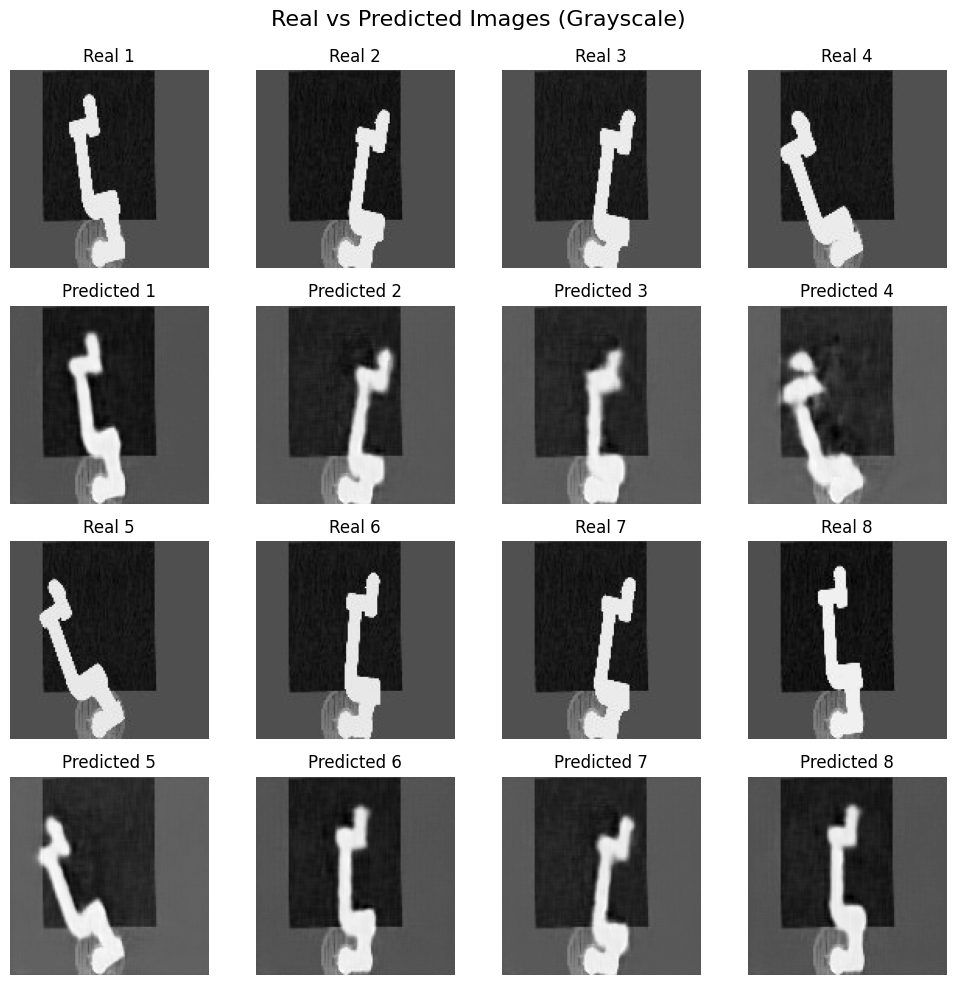

In [14]:
# Visualize reconstructed images
for data, labels in val_ds.take(1):
    img_input = data[0]
    joint_input = data[1]
    true_img = labels[0]
    true_joint = labels[1]

    # Predict reconstructions
    predicted_img, predicted_joint = decoder_model.predict({"image_input": img_input, "npy_input": joint_input})

# # Lấy một batch từ validation dataset
# for batch in val_ds.take(1):
#     (input_images, input_joints), (real_images, real_joints) = batch

# Convert tensor sang numpy array nếu cần
real_images = true_img.numpy()  # Ground truth (thực tế)
predicted_images = predicted_img  # Dự đoán (đã có sẵn dưới dạng numpy array)



def plot_real_vs_predicted(real_images, predicted_images, n=8):
    # # Lấy một batch từ validation dataset
    # for batch in val_ds.take(1):
    #     (input_images, input_joints), (real_images, real_joints) = batch

    # # Convert tensor sang numpy array nếu cần
    # real_images = real_images.numpy()
    # predicted_images = np.array(predicted_images)  # Convert predicted_images nếu cần
    
    # Đảm bảo n không vượt quá số lượng ảnh trong batch
    n = min(n, real_images.shape[0], predicted_images.shape[0])
    
    cols = min(4, n)  # Giới hạn số cột để giữ ảnh lớn hơn
    rows = (n + cols - 1) // cols  # Số hàng được tính tự động để vừa với n ảnh

    # Tạo một figure để hiển thị ảnh
    fig, axes = plt.subplots(2 * rows, cols, figsize=(10, 10))  # Gấp đôi số hàng để hiển thị cả ảnh thực tế và dự đoán
    fig.suptitle("Real vs Predicted Images (Grayscale)", fontsize=16)

    # Plot ảnh thực tế và dự đoán
    for i in range(n):
        # Plot ảnh thực tế
        ax_real = axes[2 * (i // cols), i % cols]  # Dòng chẵn: ảnh thực tế
        ax_real.imshow(real_images[i, :, :, 0], cmap='gray')
        ax_real.axis("off")
        ax_real.set_title(f"Real {i+1}")

        # Plot ảnh dự đoán
        ax_pred = axes[2 * (i // cols) + 1, i % cols]  # Dòng lẻ: ảnh dự đoán
        ax_pred.imshow(predicted_images[i, :, :, 0], cmap='gray')
        ax_pred.axis("off")
        ax_pred.set_title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Điều chỉnh tiêu đề không bị chèn lên các ảnh
    plt.show()

# Sử dụng hàm với n ảnh tùy chỉnh
plot_real_vs_predicted(real_images, predicted_images, n=8)



In [12]:
decoder_model.save_weights("reconstruct_simple_cnn.weights.h5")

In [13]:
decoder_model.summary()

Model: "DownstreamModelWithDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ npy_input           │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SimpleImageNetwork  │ (None, 30)        │     97,118 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ JointStateNetwork   │ (None, 10)        │         90 │ npy_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ SimpleImageNetwo… │
│ (Concatenate)       │                   │            │ JointStateNetwor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 20)        │        820 │ concatenate_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ [(None, 128, 128, │  1,118,371 │ latent_space[0][… │
│ (Functional)        │ 1), (None, 8)]    │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,649,199 (13.92 MB)

 Trainable params: 1,216,399 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,432,800 (9.28 MB)